In [1]:
import snscrape.modules.twitter as sntwitter
import csv
import pandas as pd
import time
import re  
from wordcloud import WordCloud# Join the different processed titles together.
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore", DeprecationWarning)# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
import os
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict
import pyLDAvis.gensim
import tempfile
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from IPython.display import display
from apyori import apriori
import spacy
from vaderSentiment import vaderSentiment
from datetime import datetime, timedelta
import pandas_bokeh
from nrclex import NRCLex

%matplotlib inline

init_notebook_mode(connected=True) #do not miss this line
warnings.filterwarnings("ignore")

# Search Query

In [2]:
#############################################################
#############################################################
##                                                         ##
##  INPUT SEARCH QUERY TO SCRAPE TWEETS AND NAME CSV FILE  ##
##                                                         ##
#############################################################
#############################################################


keyword = 'McConnell'

maxTweets = 5000


#Open/create a file to append data to
dt = datetime.now().strftime("%d%b%Y_%H%M") # ("%d_%b_%Y_%H_%M_%S")  --  add %S for seconds
csvFile = open('twitter_data/twitter_{}_{}_{}.csv'.format(keyword, maxTweets, dt), 'a', newline='', encoding='utf8')
csvWriter = csv.writer(csvFile)
csvWriter.writerow(['id','date','tweet']) 

for i,tweet in enumerate(sntwitter.TwitterSearchScraper(keyword).get_items()) :
        if i > maxTweets :
            break      
        csvWriter.writerow([tweet.id, tweet.date, tweet.content])
csvFile.close()

In [3]:
##################################################
# SPECIFY ADDITIONAL WORDS AND ARTEFACTS TO DELETE
##################################################

delete_words = ["amp", "https", "http", "n't", "'s", "'m", "www", "nan"]

# Load data

In [4]:
filename = 'twitter_data/twitter_{}_{}_{}.csv'.format(keyword, maxTweets, dt)

In [5]:
# filename = 'twitter_data/ggggggggg.csv'

# EDA

In [6]:
pd.set_option('max_colwidth',150)
tweets = pd.read_csv(filename)
tweets.columns = ['ID', 'Datetime', 'Text']
# Convert tweets to strings and lower case
tweets['Text'] = tweets['Text'].astype(str)
tweets['Text'] = tweets['Text'].map(lambda x: x.lower())
print("Total tweets:   ", len(tweets))
print("Start datetime (UTC): ", tweets.Datetime.min())
print("End datetime (UTC):   ", tweets.Datetime.max())

# tweets

Total tweets:    5001
Start datetime (UTC):  2020-11-22 23:53:09+00:00
End datetime (UTC):    2020-12-03 08:37:28+00:00


# Filter data by date

In [7]:
datetime.utcnow()

datetime.datetime(2020, 12, 3, 8, 38, 31, 576058)

In [8]:
yesterday_datetime = datetime.utcnow() - timedelta(2)  # datetime 24 hours earlier (1)
yesterday_datetime = yesterday_datetime.strftime("%Y-%m-%d %H:%M:%S")
tweets = tweets.query('Datetime >= "{}+00:00"'.format(yesterday_datetime))
print("Starting datetime: ", tweets.Datetime.min())
print("Total tweets:      ", len(tweets))

Starting datetime:  2020-12-03 04:00:14+00:00
Total tweets:       4951


# Identify duplicated tweets

In [9]:
duplicated_tweets = tweets.loc[tweets.duplicated(subset = ['Text'], keep = 'first')]
unique_duplicated_tweets = pd.DataFrame(duplicated_tweets['Text']).drop_duplicates(subset = 'Text', keep = 'first')
print("Total duplicated Tweets: ", len(duplicated_tweets))
print("Total unique duplicated Tweets: ", len(unique_duplicated_tweets))

Total duplicated Tweets:  95
Total unique duplicated Tweets:  38


In [10]:
# count duplicated tweets using groupby
dup_tweets = tweets.groupby(tweets.Text.tolist()).size().reset_index().rename(columns={0:'frequency'})
dup_tweets = dup_tweets.query('frequency > 1').sort_values(by ='frequency', ascending = False, inplace = False)
pd.set_option('display.max_rows', len(dup_tweets))

In [11]:
pandas_bokeh.output_notebook()

if len(dup_tweets) > 0:
    dup_tweets.plot_bokeh(kind = 'line',
                      x = 'index',
                      y = 'frequency', 
                      xlabel = 'Tweet',
                      ylabel = 'Frequency',
                      title = 'Number of retweets',
                      figsize = (800, 400),
                      xticks = "")
else:
    pass

Loading BokehJS ...

In [12]:
dup_tweets

index  \
4405  please include $11m funding for pzp humane fertility control in final spending bill. it’s right for #wildhorses &amp; taxpayers! @speakerpelosi @s...   
3517  @washingtonpost trump and his campaign are telling people to boycott the georgia election.the choice for republicans is who do you support donald ...   
4550  the bipartisan covid deal america urgently needs is now on the table thanks to @senatorcollins @sen_joemanchin, &amp; @senbillcassidy. it's time f...   
1812  @realdonaldtrump how in the world does the gop support a president that shouts baseless claims of fraud? he’s raked in $170,000,000 from donors si...   
1872  @reallyamerican1 it's not over after putrump leaves office.\n\nmcconnell will work daily to sabotage biden's legislation &amp; the nation itself.\...   
468   @cnn trump and his campaign are telling people to boycott the georgia election.the choice for republicans is who do you support donald trump or mi...   
942   @independent trump and his campaign are telling people to boycott the georgia election.the choice for republicans is who do you support donald tru...   
148   @abc trump and his campaign are telling people to boycott the georgia election.the choice for republicans is who do you support donald trump or mi...   
1574  @nytimes trump and his campaign are telling people to boycott the georgia election.the choice for republicans is who do you support donald trump o...   
1723  @realdonaldtrump @cnnbrk @foxnews @senatemajldr @joebiden \n\nin an hour of lies and drivel you spewed, 100 americans died from covid-19.\n\ndo yo...   
4538  thanks to @senatorcollins @sen_joemanchin, &amp; @senbillcassidy the bipartisan covid deal america urgently needs is now on the table. it's time f...   
3434  @timalberta it's not over after putrump leaves office.\n\nmcconnell will work daily to sabotage biden's legislation &amp; the nation itself.\n\nth...   
2435                                                                                                                  @senatemajldr https://t.co/dq9aqus1xr   
2146  @senatemajldr #realdonaldtrump cares for nobody but himself \n\ncontinues to divide us🇺🇸 \n\ncontinues baseless claims that \ncourts\nag\ndhs\ncon...   
1871  @reallyamerican1 it's not over after putrump leaves office.\n\nmcconnell will work daily to sabotage biden's legislation &amp; the nation itself.\...   
736   @frankamari2 @senatemajldr what? #mitchmcconnell , you were crying on the floor today!\nnot for the 2,700 precious lives lost today to #covid_19 ,...   
1664  @politico trump and his campaign are telling people to boycott the georgia election.the choice for republicans is who do you support donald trump ...   
535   @danrather it's not over after putrump leaves office.\n\nmcconnell will work daily to sabotage biden's legislation &amp; the nation itself.\n\nthe...   
1104  @jonathanvswan it's not over after putrump leaves office.\n\nmcconnell will work daily to sabotage biden's legislation &amp; the nation itself.\n\...   
398   @cbsnews trump and his campaign are telling people to boycott the georgia election.the choice for republicans is who do you support donald trump o...   
1222  @lambejerry it's not over after putrump leaves office.\n\nmcconnell will work daily to sabotage biden's legislation &amp; the nation itself.\n\nth...   
1315  @loudobbs trump and his campaign are telling people to boycott the georgia election.the choice for republicans is who do you support donald trump ...   
3278  @steverustad1 it's not over after putrump leaves office.\n\nmcconnell will work daily to sabotage biden's legislation &amp; the nation itself.\n\n...   
3252  @speakerpelosi 🔥 happy #covid19\n\nfrom: #gop \n\nto: american people\n\n💸$900 billion\n\n🚫 no stimulus checks in the new stimulus bill\n\nsincere...   
2959                                                                                                                                        @senatemajldr 🖕   
2831  @senatemaj

In [45]:
index_num = 4405

if index_num in dup_tweets.index: display(dup_tweets['index'].loc[index_num])

'please include $11m funding for pzp humane fertility control in final spending bill. it’s right for #wildhorses &amp; taxpayers! @speakerpelosi @senatemajldr @senschumer @nitalowey @senatorleahy @bettymccollum04 @gopleader @senshelby @senateapprops @appropsdems'

# Drop duplicates

In [14]:
# tweets.drop_duplicates(subset = ['Text'], keep = 'first', inplace = True)
print("Total tweets without duplicates: ", len(tweets))

Total tweets without duplicates:  4951


# Drop rows containing keywords

In [15]:
remove_SPAM = pd.DataFrame()
remove_SPAM = tweets[tweets['Text'].str.contains("gggggggggg")] 

remove_SPAM_index = remove_SPAM.index.tolist()
tweets.drop(remove_SPAM_index, inplace = True)
tweets.reset_index()
tweets_original = tweets  # for search function below
print("Total tidied replies: ", len(tweets))

Total tidied replies:  4951


# Extract hashtags

In [16]:
def search_hashtag(string):
    pat = r'(\w*%s\w*)' % "#"      # find strings containing '#'
    return re.findall(pat, string)

hashtags = pd.DataFrame()  # add hashtags to new dataframe
hashtags['list'] = tweets['Text'].apply(lambda row: search_hashtag(row))  
hashtags_tokenised = pd.DataFrame()  
hashtags_tokenised['hashtags'] = hashtags.apply(lambda x: pd.Series(x['list']),axis=1).stack().reset_index(level=1, drop=True)
total_number_hashtags = len(hashtags_tokenised.hashtags.unique())
print("Total number of unique hashtags: ", total_number_hashtags)

Total number of unique hashtags:  740


# Identify top hashtags

In [17]:
hash_list = hashtags_tokenised['hashtags'].str.split(expand=True).stack().value_counts()
top_hashtags = pd.DataFrame(hash_list).reset_index()
top_hashtags.columns = ['hashtag', 'frequency']

In [18]:
pandas_bokeh.output_notebook()

top_hashtags.plot_bokeh(kind = 'line',
                      x = 'hashtag',
                      y = 'frequency', 
                      xlabel = 'Hashtag',
                      ylabel = 'Frequency',
                      title = 'Top hashtags',
                      figsize = (800, 400),
                      xticks = "")

Loading BokehJS ...

Figure(id='1093', ...)

In [19]:
pd.set_option('display.max_rows', len(top_hashtags))

top_hashtags_styler = top_hashtags.style.set_properties(**{'text-align': 'left'})
top_hashtags_styler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

# Define apriori association rules

In [20]:
# Subset data for more manageable apriori analysis

# hashtags_subset = hashtags['list'].sample(n = 2500)

In [48]:
# Swap hashtags['list'] with hashtags_subset if apriori becomes too computationally complex
hashtags_list = hashtags['list'].tolist()
association_rules = apriori(hashtags_list, min_support=0.0005, min_confidence=0.1, min_lift=1, min_length=2)
association_results = list(association_rules)
len(association_results)

226

In [22]:
# association_results[0]

In [49]:
# Convert rules to dataframe

df = pd.DataFrame(columns=('Items','Antecedent','Consequent','Support','Confidence','Lift'))

Support =[]
Confidence = []
Lift = []
Items = []
Antecedent = []
Consequent=[]

for RelationRecord in association_results:
    for ordered_stat in RelationRecord.ordered_statistics:
        Support.append(RelationRecord.support)
        Items.append(RelationRecord.items)
        Antecedent.append(ordered_stat.items_base)
        Consequent.append(ordered_stat.items_add)
        Confidence.append(ordered_stat.confidence)
        Lift.append(ordered_stat.lift)

df['Items'] = Items                          
df['Antecedent'] = Antecedent
df['Consequent'] = Consequent
df['Support'] = Support
df['Confidence'] = Confidence
df['Lift']= Lift

### Association results

In [50]:
pd.set_option('display.max_rows', df.shape[0]+1)

df.sort_values(by ='Support', ascending = False, inplace = False)

Items  \
83                                                             (#gopcorruptionovercountry, #gophypocrisy)   
82                                                             (#gopcorruptionovercountry, #gophypocrisy)   
87                                                                            (#reliefnow, #gophypocrisy)   
455                                                (#reliefnow, #gopcorruptionovercountry, #gophypocrisy)   
23                                                                               (#depression, #covid_19)   
24                                                                           (#mitchmcconnell, #covid_19)   
25                                                                           (#mitchmcconnell, #covid_19)   
278                                                             (#depression, #covid_19, #mitchmcconnell)   
279                                                             (#depression, #covid_19, #mitchmcconnell)   
280                                                             (#depression, #covid_19, #mitchmcconnell)   
46                                                                         (#depression, #mitchmcconnell)   
457                                                (#reliefnow, #gopcorruptionovercountry, #gophypocrisy)   
456                                                (#reliefnow, #gopcorruptionovercountry, #gophypocrisy)   
277                                                             (#depression, #covid_19, #mitchmcconnell)   
458                                                (#reliefnow, #gopcorruptionovercountry, #gophypocrisy)   
459                                                (#reliefnow, #gopcorruptionovercountry, #gophypocrisy)   
460                                                (#reliefnow, #gopcorruptionovercountry, #gophypocrisy)   
84                                                                (#reliefnow, #gopcorruptionovercountry)   
85                                                                (#reliefnow, #gopcorruptionovercountry)   
86                                                                            (#reliefnow, #gophypocrisy)   
22                                                                               (#depression, #covid_19)   
47                                                                         (#depression, #mitchmcconnell)   
276                                                             (#depression, #covid_19, #mitchmcconnell)   
275                                                             (#depression, #covid_19, #mitchmcconnell)   
45                                                                                 (#demoncrates, #rinos)   
44                                                                                 (#demoncrates, #rinos)   
102                                                                               (#lalate, #purplepower)   
103                                                                               (#lalate, #purplepower)   
28                                                                           (#purplepower, #cr4stimulus)   
29                                                                           (#purplepower, #cr4stimulus)   
182                                                        (#eviction, #americansstarving, #unemployment)   
569                                             (#crisis, #americansstarving, #reliefcantwait, #eviction)   
183                                                        (#eviction, #americansstarving, #unemployment)   
572                                             (#crisis, #americansstarving, #reliefcantwait, #eviction)   
571                                             (#crisis, #americansstarving, #reliefcantwait, #eviction)   
570                                             (#crisis, #americansstarving, #reliefcantwait, #eviction)   
567                                             (#crisis, #american

### Unique Item Combinations

In [51]:
df_unique_hashtag_items = df.drop_duplicates(subset = ['Items'], keep = 'first', inplace = False)
df_unique_hashtag_items.sort_values(by ='Support', ascending = False, inplace = True)

df_unique_hashtag_items[['Items', 'Support']]

Items  \
82                                                             (#gopcorruptionovercountry, #gophypocrisy)   
455                                                (#reliefnow, #gopcorruptionovercountry, #gophypocrisy)   
46                                                                         (#depression, #mitchmcconnell)   
84                                                                (#reliefnow, #gopcorruptionovercountry)   
86                                                                            (#reliefnow, #gophypocrisy)   
275                                                             (#depression, #covid_19, #mitchmcconnell)   
22                                                                               (#depression, #covid_19)   
24                                                                           (#mitchmcconnell, #covid_19)   
44                                                                                 (#demoncrates, #rinos)   
102                                                                               (#lalate, #purplepower)   
28                                                                           (#purplepower, #cr4stimulus)   
0                                                                           (#crisis, #americansstarving)   
164                                                        (#crisis, #americansstarving, #reliefcantwait)   
883                                                  (#crisis, #reliefcantwait, #unemployment, #eviction)   
365                                                           (#eviction, #reliefcantwait, #unemployment)   
2                                                                         (#eviction, #americansstarving)   
299                                                                   (#crisis, #unemployment, #eviction)   
305                                                             (#crisis, #reliefcantwait, #unemployment)   
56                                                                           (#eviction, #reliefcantwait)   
293                                                                 (#crisis, #reliefcantwait, #eviction)   
126                                                                                  (#trump, #mcconnell)   
132                                                              (#stimuluscheckorshutdown, #purplepower)   
1191                             (#eviction, #reliefcantwait, #crisis, #americansstarving, #unemployment)   
144                                                                      (#reliefcantwait, #unemployment)   
188                                                  (#americansstarving, #reliefcantwait, #unemployment)   
182                                                        (#eviction, #americansstarving, #unemployment)   
176                                                      (#eviction, #americansstarving, #reliefcantwait)   
170                                                          (#crisis, #americansstarving, #unemployment)   
58                                                                             (#eviction, #unemployment)   
78                                                       (#gopcorruptionovercountry, #gopbetrayedamerica)   
158                                                              (#crisis, #americansstarving, #eviction)   
36                                                                               (#crisis, #unemployment)   
4                                                                   (#americansstarving, #reliefcantwait)   
6                                                                     (#americansstarving, #unemployment)   
605                                       (#eviction, #americansstarving, #reliefcantwait, #unemployment)   
591                                         (#crisis, #americansstarving, #reliefcantwait, #unemployment)   
577                                               (#crisis, #americ

# Identify Apriori rows containing specific hashtag

In [52]:
#############
# ITEM SEARCH
#############


ITEM_SEARCH = '#cr4stimulus'


df_search = df[df.Items.apply(lambda x: ITEM_SEARCH in x)]
print("Hashtag " + ITEM_SEARCH +" occurrences: ", len(df_search))
df_search.head(50)

Hashtag #cr4stimulus occurrences:  18


Items  \
26                                  (#lalate, #cr4stimulus)   
27                                  (#lalate, #cr4stimulus)   
28                             (#purplepower, #cr4stimulus)   
29                             (#purplepower, #cr4stimulus)   
30                 (#stimuluscheckorshutdown, #cr4stimulus)   
31                 (#stimuluscheckorshutdown, #cr4stimulus)   
281                   (#lalate, #purplepower, #cr4stimulus)   
282                   (#lalate, #purplepower, #cr4stimulus)   
283                   (#lalate, #purplepower, #cr4stimulus)   
284                   (#lalate, #purplepower, #cr4stimulus)   
285                   (#lalate, #purplepower, #cr4stimulus)   
286                   (#lalate, #purplepower, #cr4stimulus)   
287  (#stimuluscheckorshutdown, #purplepower, #cr4stimulus)   
288  (#stimuluscheckorshutdown, #purplepower, #cr4stimulus)   
289  (#stimuluscheckorshutdown, #purplepower, #cr4stimulus)   
290  (#stimuluscheckorshutdown, #purplepower, #cr4stimulus)   
291  (#stimuluscheckorshutdown, #purplepower, #cr4stimulus)   
292  (#stimuluscheckorshutdown, #purplepower, #cr4stimulus)   

                                   Antecedent  \
26                             (#cr4stimulus)   
27                                  (#lalate)   
28                             (#cr4stimulus)   
29                             (#purplepower)   
30                             (#cr4stimulus)   
31                 (#stimuluscheckorshutdown)   
281                            (#cr4stimulus)   
282                                 (#lalate)   
283                            (#purplepower)   
284                   (#lalate, #cr4stimulus)   
285              (#purplepower, #cr4stimulus)   
286                   (#lalate, #purplepower)   
287                            (#cr4stimulus)   
288                            (#purplepower)   
289                (#stimuluscheckorshutdown)   
290              (#purplepower, #cr4stimulus)   
291  (#stimuluscheckorshutdown, #cr4stimulus)   
292  (#stimuluscheckorshutdown, #purplepower)   

                                   Consequent   Support  Confidence  \
26                                  (#lalate)  0.001212    0.315789   
27                             (#cr4stimulus)  0.001212    0.352941   
28                             (#purplepower)  0.001818    0.473684   
29                             (#cr4stimulus)  0.001818    0.360000   
30                 (#stimuluscheckorshutdown)  0.001010    0.263158   
31                             (#cr4stimulus)  0.001010    0.277778   
281                   (#lalate, #purplepower)  0.001212    0.315789   
282              (#purplepower, #cr4stimulus)  0.001212    0.352941   
283                   (#lalate, #cr4stimulus)  0.001212    0.240000   
284                            (#purplepower)  0.001212    1.000000   
285                                 (#lalate)  0.001212    0.666667   
286                            (#cr4stimulus)  0.001212    0.500000   
287  (#stimuluscheckorshutdown, #purplepower)  0.000606    0.157895   
288  (#stimuluscheckorshutdown, #cr4stimulus)  0.000606    0.120000   
289              (#purplepower, #cr4stimulus)  0.000606    0.166667   
290                (#stimuluscheckorshutdown)  0.000606    0.333333   
291                            (#purplepower)  0.000606    0.600000   
292                            (#cr4stimulus)  0.000606    0.428571   

           Lift  
26    91.969040  
27    91.969040  
28    93.808421  
29    93.808421  
30    72.383041  
31    72.383041  
281  130.289474  
282  194.156863  
283  198.040000  
284  198.040000  
285  194.156863  
286  130.289474  
287  111.676692  
288  118.824000  
289   91.685185  
290   91.685185  
291  118.824000  
292  111.676692

# Identify top mentions

In [27]:
def search_mentions(string):
    pat = r'(\w*%s\w*)' % "@"      
    return re.findall(pat, string)

mentions = pd.DataFrame()  # add hashtags to new dataframe
mentions['list'] = tweets['Text'].apply(lambda row: search_mentions(row))  
mentions_tokenised = pd.DataFrame()  
mentions_tokenised['mentions'] = mentions.apply(lambda x: pd.Series(x['list']),axis=1).stack().reset_index(level=1, drop=True)
total_number_mentions = len(mentions_tokenised.mentions.unique())
print("Total number of unique mentions: ", total_number_mentions)
mentions_list = mentions_tokenised['mentions'].str.split(expand=True).stack().value_counts()

Total number of unique mentions:  2648


In [28]:
pd.set_option('display.max_rows', len(mentions_list))
top_mentions = pd.DataFrame(mentions_list).reset_index()
top_mentions.columns = ['mention', 'frequency']

In [29]:
pandas_bokeh.output_notebook()

top_mentions.plot_bokeh(kind = 'line',
                        x = 'mention',
                        y = 'frequency', 
                        xlabel = 'Mentions',
                        ylabel = 'Frequency',
                        title = 'Top mentions',
                        figsize = (800, 400),
                        xticks = "")

Loading BokehJS ...

Figure(id='1187', ...)

In [30]:
top_mentions

top_mentions_styler = top_mentions.style.set_properties(**{'text-align': 'left'})
top_mentions_styler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

### Extract nouns, verbs and adjectives

In [31]:
lemmatizer = nltk.WordNetLemmatizer()

def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label() =='NP'):
        yield subtree.leaves()       
def get_word_postag(word):
    if pos_tag([word])[0][1].startswith('J'):
        return wordnet.ADJ
    if pos_tag([word])[0][1].startswith('V'):
        return wordnet.VERB
    if pos_tag([word])[0][1].startswith('N'):
        return wordnet.NOUN
    else:
        return wordnet.NOUN  
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    postag = get_word_postag(word)
    word = lemmatizer.lemmatize(word,postag)
    return word
def get_terms(tree):    
    for leaf in leaves(tree):
        terms = [normalise(w) for w,t in leaf]
        yield terms  
        
tidied_tweets = []        
for t in tweets['Text']:
    #word tokenizeing and part-of-speech tagger
    document = t
    tokens = [nltk.word_tokenize(sent) for sent in [document]]
    postag = [nltk.pos_tag(sent) for sent in tokens][0]    
    # Rule for NP chunk and VB Chunk
    grammar = r"""
        NBAR:
            {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
            {<RB.?>*<VB.?>*<JJ>*<VB.?>+<VB>?} # Verbs and Verb Phrases            
        NP:
            {<NBAR>}
            {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...           
    """
    #Chunking
    cp = nltk.RegexpParser(grammar)    
    # the result is a tree
    tree = cp.parse(postag)    
    terms = get_terms(tree)    
    features = []
    for term in terms:
        _term = ''
        for word in term:
            _term += ' ' + word
        features.append(_term.strip())      
    tidied_tweets.append(features) 
tweet_list = [[] for i in range(len(tidied_tweets))]
for tweets, t in zip(tidied_tweets, range(len(tidied_tweets))):
    for words in tweets:
        a = re.findall(r"[\w']+", words)  ## ADD JUST THIS TO THE NEW CODE AND TIDY OUTPUT
        tweet_list[t].append(a)       
# Remove empty lists from tweet_list if delete_words leaves anything empty
tweet_list = [x for x in tweet_list if x != []]
        
# Un-nest inner most list (individual words)
from functools import reduce
single_list = []
for t in tweet_list:
    a = reduce(lambda x,y: x+y, t)
    single_list.append(a)  
single_list = [[y for y in x if y not in delete_words] for x in single_list]
# Converted child list to string in new 'tidied_list'
tidied_list = []
separator = " "
for l in single_list:
    a = separator.join(l)
    tidied_list.append(a)  
tweets = pd.DataFrame(tidied_list, columns = ['Text_processed'])

# Exploratory Analysis

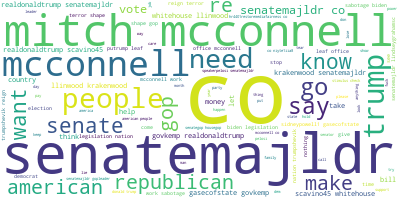

In [32]:
long_string = ','.join(list(tweets['Text_processed'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

# Prepare text for LDA analysis

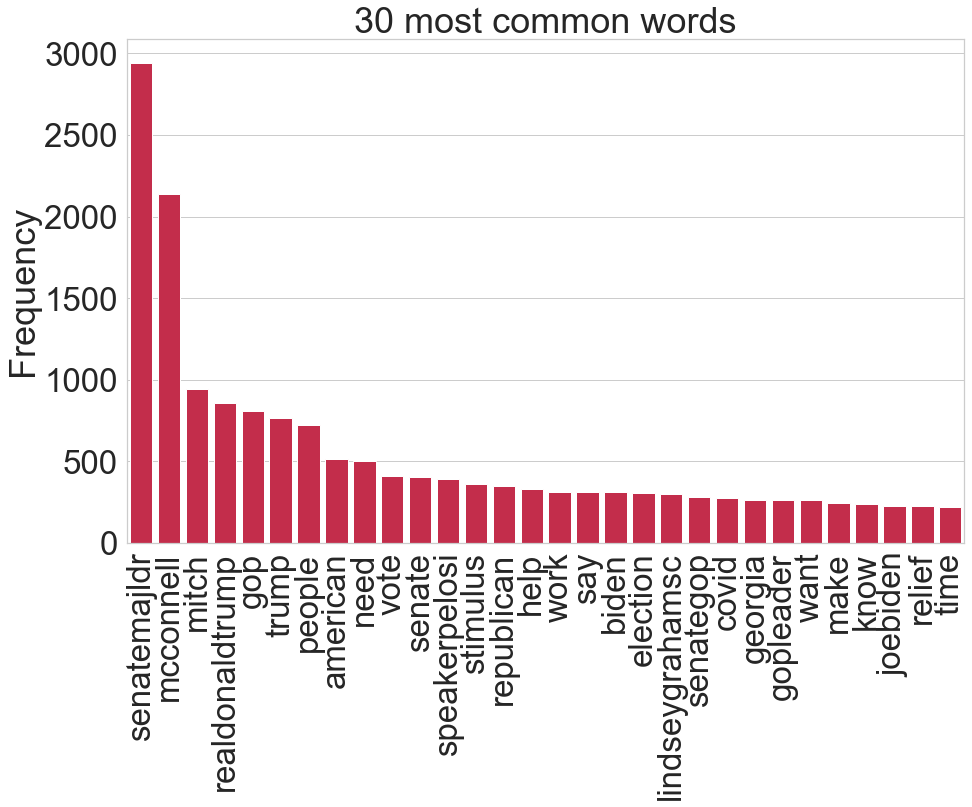

In [64]:
sns.set_style('whitegrid')
%matplotlib inline  
def plot_30_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]   
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:30]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='30 most common words')
    sns.set_context("notebook", font_scale=3, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, color='crimson')
    plt.xticks(x_pos, words, rotation=90) 
    plt.ylabel('Frequency')
    plt.show()# Initialise the count vectorizer with the English stop words   
count_vectorizer = CountVectorizer(stop_words='english')# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(tweets['Text_processed']) # Visualise the 30 most common words
plot_30_most_common_words(count_data, count_vectorizer)

# Total topics

In [65]:
################
##  TOTAL TOPICS
################

total_topics = int(input("Total topics: "))

Total topics: 4


# LDA model training and results visualization

In [66]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))       
# Tweak the two parameters below
number_words = 20  # Create and fit the LDA model
lda = LDA(n_components=total_topics, n_jobs=-1)
lda.fit(count_data)

# print("Topics found via LDA:")
# print_topics(lda, count_vectorizer, number_words)

LatentDirichletAllocation(n_components=4, n_jobs=-1)

# Using pyLDAvis with twitter data

In [67]:
# Preparing a corpus for analysis and checking first 5 entries
corpus=[]
a=[]
for i in range(len(tweets['Text_processed'])):
        a=tweets['Text_processed'][i]
        corpus.append(a)  
        
# corpus[0:5]

In [68]:
# create temp folder
TEMP_FOLDER = tempfile.gettempdir()
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# removing common words and tokenizing
list1 = ['RT','rt']
stoplist = stopwords.words('english') + list(punctuation) + list1
texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]  # reused in paragraph search below
dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'elon.dict'))  # store the dictionary, for future reference
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'elon.mm'), corpus)  # store to disk, for later
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vectors
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold

2020-12-03 20:02:46,542 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-12-03 20:02:46,627 : INFO : built Dictionary(10876 unique tokens: ['american', 'co', 'funny', 'mcconnell', 'mitch']...) from 4951 documents (total 74126 corpus positions)
2020-12-03 20:02:46,628 : INFO : saving Dictionary object under C:\Users\61437\AppData\Local\Temp\elon.dict, separately None
2020-12-03 20:02:46,632 : INFO : saved C:\Users\61437\AppData\Local\Temp\elon.dict
2020-12-03 20:02:46,687 : INFO : storing corpus in Matrix Market format to C:\Users\61437\AppData\Local\Temp\elon.mm
2020-12-03 20:02:46,688 : INFO : saving sparse matrix to C:\Users\61437\AppData\Local\Temp\elon.mm
2020-12-03 20:02:46,689 : INFO : PROGRESS: saving document #0
2020-12-03 20:02:46,708 : INFO : PROGRESS: saving document #1000
2020-12-03 20:02:46,726 : INFO : PROGRESS: saving document #2000
2020-12-03 20:02:46,744 : INFO : PROGRESS: saving document #3000
2020-12-03 20:02:46,762 : INFO : PROGRESS: saving docume

In [69]:
# Create ordered dictionary
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
# print(df_lda.shape)

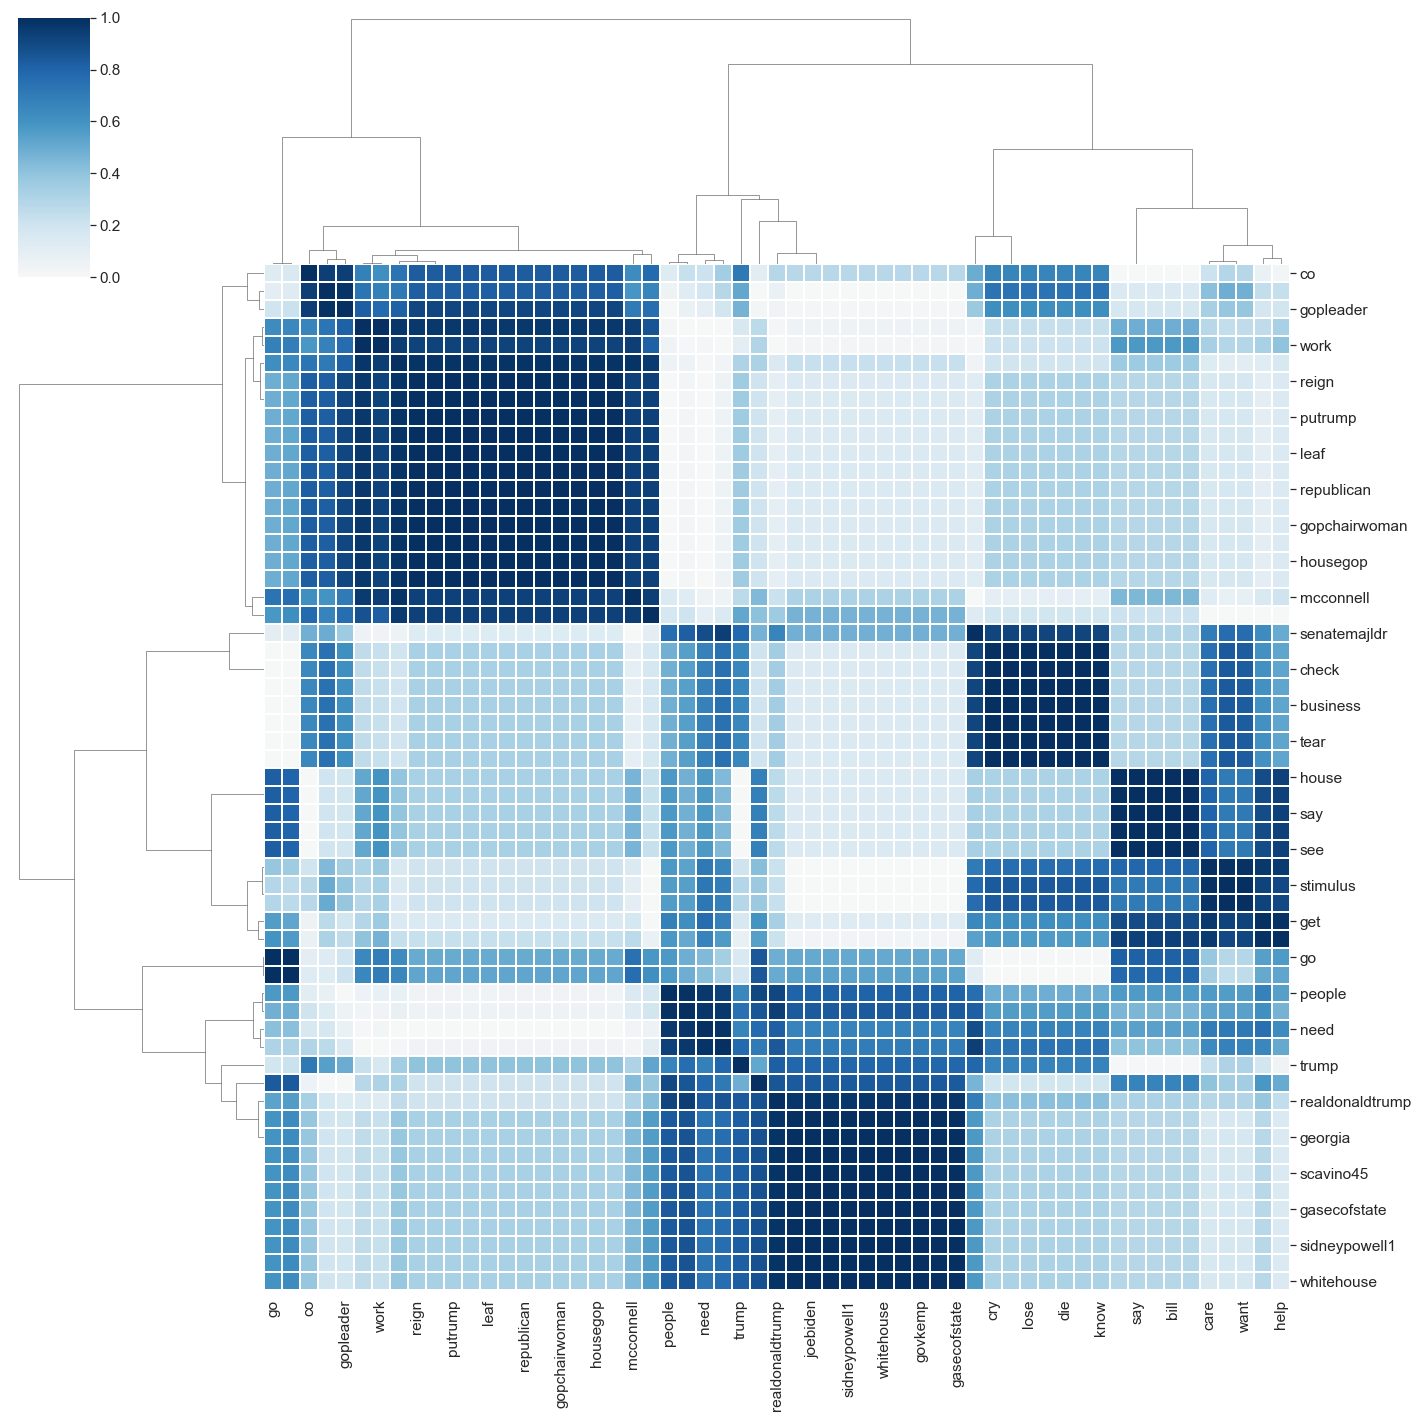

In [70]:
sns.set(font_scale=1.4)
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(20, 20))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis

#### Show first n important words in the topics

In [71]:
#Show first n important word in the topics:
lda_list = lda.show_topics(total_topics, 50)
topic_df = pd.DataFrame()
for t in range(total_topics):
    lda_list_n = lda_list[t][1].split(" + ")  # split includes a space around the '+'
    topic_df["Word " + str(t + 1)] = [i.split('*')[1] for i in lda_list_n]
    topic_df["Score " + str(t + 1)] = [i.split('*')[0] for i in lda_list_n]  
    
# topic_df

In [72]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      269.562408 -124.803398       1        1  37.534472
3        1.782994 -295.079681       2        1  35.698149
2      220.811432 -343.832123       3        1  13.601542
1       50.533993  -76.050934       4        1  13.165837, topic_info=                            Term        Freq       Total Category  logprob  \
23                  senatemajldr  160.000000  160.000000  Default  30.0000   
1                             co  128.000000  128.000000  Default  29.0000   
155                         bill   18.000000   18.000000  Default  28.0000   
35               realdonaldtrump   47.000000   47.000000  Default  27.0000   
1174                    llinwood   13.000000   13.000000  Default  26.0000   
55                           get   33.000000   33.000000  Default  25.0000   
1173                  krakenwood   11.000000   11.000000  Default  24.0000   
1175                   scavino45   11.000000   11.000000  Default  23.0000   
1171                gasecofstate   11.000000   11.000000  Default  22.0000   
1093                  whitehouse   13.000000   13.000000  Default  21.0000   
41                        people   33.000000   33.000000  Default  20.0000   
229                sidneypowell1   13.000000   13.000000  Default  19.0000   
3                      mcconnell  140.000000  140.000000  Default  18.0000   
0                       american   25.000000   25.000000  Default  17.0000   
352                         tear    6.000000    6.000000  Default  16.0000   
230                         help   19.000000   19.000000  Default  15.0000   
117                      govkemp   12.000000   12.000000  Default  14.0000   
1076                      office   13.000000   13.000000  Default  13.0000   
340                         vote   20.000000   20.000000  Default  12.0000   
49                         biden   24.000000   24.000000  Default  11.0000   
4015                      punish    7.000000    7.000000  Default  10.0000   
165                        trump   36.000000   36.000000  Default   9.0000   
264                     election   12.000000   12.000000  Default   8.0000   
212                         need   28.000000   28.000000  Default   7.0000   
2335                      nation    9.000000    9.000000  Default   6.0000   
2334  hr4401restoremediafairness    7.000000    7.000000  Default   5.0000   
2337                     putrump    7.000000    7.000000  Default   4.0000   
3913                        foul    6.000000    6.000000  Default   3.0000   
2340                 trumpshevik    7.000000    7.000000  Default   2.0000   
3915                       spawn    6.000000    6.000000  Default   1.0000   
4015                      punish    7.161455    7.234292   Topic1  -5.5587   
3915                       spawn    6.347879    6.454906   Topic1  -5.6793   
3913                        foul    6.513330    6.628508   Topic1  -5.6536   
3806                     current    1.992802    2.035017   Topic1  -6.8379   
378                      tribute    1.496087    1.529655   Topic1  -7.1246   
4713                     martini    1.565462    1.601795   Topic1  -7.0793   
4712                       lunch    1.458950    1.496486   Topic1  -7.1497   
1156                          ai    1.319824    1.359381   Topic1  -7.2499   
562                          key    1.314921    1.355236   Topic1  -7.2537   
2066                      theory    1.294543    1.336970   Topic1  -7.2693   
5012                     rbreich    1.040829    1.075914   Topic1  -7.4874   
5700                    violence    1.302488    1.347107   Topic1  -7.2632   
3780                        grim    1.384599    1.432738   Topic1  -7.2020   
559                          esp    0.948800    0.982616   Topic1  -7.5800   
359                         jail    1.152835    1.194372   Topic1  -7.3852   
641                  

In [73]:
# Sentiment analysis functions

def analyse_corpus_sentiment(text):
    english = spacy.load("en_core_web_sm") 
    negative = []
    neutral = []
    positive = []
    compound = []
    for t in text:
        result = english(t)
        sentences = [str(s) for s in result.sents]
        analyzer = vaderSentiment.SentimentIntensityAnalyzer()
        sentiment = [analyzer.polarity_scores(str(s)) for s in sentences]
        negative.append(sentiment[0]['neg'])
        neutral.append(sentiment[0]['neu'])
        positive.append(sentiment[0]['pos'])
        compound.append(sentiment[0]['compound'])
    sentiment_score = pd.DataFrame()
    sentiment_score['Negative'] = [round(np.mean(negative), 3)]
    sentiment_score['Neutral'] = [round(np.mean(neutral), 3)]
    sentiment_score['Positive'] = [round(np.mean(positive), 3)]
    sentiment_score['Compound'] = [round(np.mean(compound), 3)]
    display(sentiment_score)
    
def sentiment_graph(DAT):
    sentiment_df = pd.DataFrame()
    for d in DAT:
        text_object = NRCLex(str(d))
        sentiment_row = pd.DataFrame.from_dict(text_object.affect_frequencies, orient = 'index').T
        sentiment_df = sentiment_df.append(sentiment_row, ignore_index = True)   
    sentiment_df.mean().sort_values(ascending = False).plot.bar(title = "Mean Sentiment Score")

# Phrase search

In [74]:
###############
# PHRASE SEARCH
###############


search_word = "purplepower"

subset_search_word = ""


# duplicate original data for search function and sentiment analysis
text_dat = tweets_original['Text'] 
# convert to lower case for search function
comments_lower = pd.DataFrame()
comments_lower['comment'] = text_dat.apply(lambda row: row.lower())  
searched_comment = comments_lower[(comments_lower['comment'].str.contains(search_word)) & 
                                  (comments_lower['comment'].str.contains(subset_search_word))] 
# Join index of 'searched_comment' with original data to restore punctuation and upper case
searched_comment_index = searched_comment.index.tolist()
sci = pd.DataFrame()
sci['index'] = searched_comment_index
sci.set_index('index', inplace = True)
searched_comment_joined = pd.merge(sci, text_dat, left_on = 'index', right_index = True)
# Remove quotation marks (“”) from text for sentiment analysis
searched_comments_tidied = searched_comment_joined.Text.map(lambda x: re.sub('[“”]', "", x))  

Searched comment length:  28



Negative  Neutral  Positive  Compound
0      0.05    0.935     0.015    -0.049

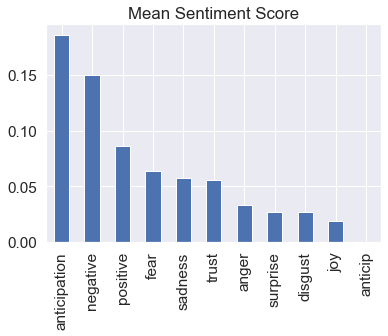

In [75]:
if len(searched_comment_joined) > 0:
    print("Searched comment length: ", len(searched_comment_joined))
    print("")
    analyse_corpus_sentiment(searched_comments_tidied)
    print("")
    sentiment_graph(searched_comments_tidied)
else:
    print("SEARCH WORD NOT IN DATASET")

In [76]:
pd.set_option('max_colwidth',600)

if len(searched_comment_joined) <= 50:
    display(searched_comment_joined.head(50))
else:
    display(searched_comment_joined.sample(n = 50).sort_values(by = 'index', ascending = True, inplace = False))

Text
index                                                                                                                                                                                                                                                                                                                           
604                                                                                                                                                                                                                                             #stimuluscheckorshutdown #purplepower @speakerpelosi @chuckschumer @senatemajldr
786                          @realdonaldtrump @probsolvecaucus @whitehouse @housedemocrats @housegop @housebluedogs @potus @housegop @senategop @flotus @vp @secondlady @teampelosi @senatemajldr @mcconnellpress \n#cr4stimulus💸 #iamvalued👩 #theamericanpeopleareallimportant 🇺🇸 #purplepower 💜#lalate https://t.co/awwibhh1yj
806                                                                                                                                                 #stimuluscheckorshutdown #purplepower   @senschumer @speakerpelosi @teampelosi @markmeadows @stevenmnuchin1 @senatemajldr @housedemocrats @senategop https://t.co/fkqqfka59b
1075                                                                             @speakerpelosi @repjoshharder @aoc @repaoc @repmarkmeadows @stevenmnuchin1 @senschumer @davidpopp @senatemajldr @housedemocrats @housebluedogs #purplepower #cr4stimulus #stimuluscheckorshutdown @gop @probsolvecaucus https://t.co/6jzrxzuz1e
1196                                                                                                                                                                                                              #stimuluscheckorshutdown @senschumer @speakerpelosi @stevenmnuchin1 @senatemajldr @potus #purplepowercheck5000
1251                                                omg! someone get rid of her! because of @speakerpelosi we’ve lost cars, homes, exhausted credit cards, savings ect. @repjoshharder @aoc @repaoc @housedemocrats @housebluedogs @repmarkmeadows @stevenmnuchin1 @senatemajldr @davidpopp #purplepower https://t.co/aqqmhkmtky
1258                  @senategop @housegop @housedemocrats @senatedems @teampelosi @senschumer @probsolvecaucus @senatemajldr @whitehouse @housebluedogs @thedemocrats @newdemcoalition \n\n#iamvalued #theamericanpeopleareallimportant 🇺🇸 #purplepower 💜 #cr4stimulus #lalate #stimuluscheckorshutdown https://t.co/pfgk8oeadn
1291                                                                               #cr4stimulus #purplepower #lalate #purplepowercaucus @stevenmnuchin1 @senatemajldr @markmeadows @senschumer \ncome walk in our shoes! take the challenge see how the real americans live daily\nwith little to no pay https://t.co/rrf0u9b9io
1321                                                                                          #purplepower #cr4stimulus @davidpopp @senatemajldr @speakerpelosi @gop @repjoshharder @probsolvecaucus @repmarkmeadows @housedemocrats @housebluedogs @aoc @repaoc @stevenmnuchin1 @potus @realdonaldtrump https://t.co/mc17gpnkdn
1692                                        @senatemajldr #shutdown4stimulus\nthis is disgusting! we have waited since april! fir example people on ssi or ssdi who font qualify for anything else.  dying, starving, can't pay electric bills.  no check in the cr then shutdown! we are tired of the bs!#lalate \n#purplepower
1781                                                          if we don't get our check , you sure don't get your check @speakerpelosi @davidpopp @stevenmnuchin1 @dougandres @markmeadows @senschumer @senatemajldr @teampelosi @gopchairwoman @gopleader #lalate #purplepower #stimuluscheckorshutdown https://t.co/5xbfr0cyrn
2405                                                                                        hey you stupid a**holes!  we demand to be heard!! w

In [77]:
index_num = 152

if index_num in searched_comment_joined.index: display(searched_comment_joined.Text.loc[index_num])